In [1]:
import numpy
from scipy import integrate
%pylab inline
from galpy.util import bovy_plot
import seaborn as sns
from matplotlib import ticker
bovy_plot.bovy_print(axes_labelsize=18.,text_fontsize=14.,xtick_labelsize=16.,ytick_labelsize=16.)

Populating the interactive namespace from numpy and matplotlib


# The Milky Way's subhalo mass function

## The classical dwarfs

We get the high-mass end by using the classical dwarfs, for which observations are complete out to 300 kpc:

In [2]:
if False:
    # From Garrison-Kimmel et al. (2017)
    sats= ['LMC','SMC','Sgr','Fornax','LeoI','Sculptor','LeoII','Sextans','Carina','Ursa Minor','Draco']
    stellarmass= numpy.array([1.06*10.**9,3.69*10.**8.,3.44*10.**7.,3.25*10.**7.,8.79*10.**6.,3.67*10.**6.,
                             1.18*10.**6.,6.98*10.**5.,6.03*10.**5.,4.53*10.**5.,4.53*10.**5.])
else:
    # From Garrison-Kimmel et al. (2019)
    sats= ['LMC','SMC','Sgr','Fornax','LeoI','Sculptor',
           'LeoII','Sextans','Carina','Ursa Minor','Draco','CVnI']
    stellarmass= numpy.array([1.1*10.**9,3.7*10.**8.,3.4*10.**7.,2.4*10.**7.,4.9*10.**6.,3.9*10.**6.,
                             1.2*10.**6.,7*10.**5.,3.8*10.**5.,5.4*10.**5.,3.2*10.**5.,3*10.**5.])

We assign a halo mass using a stellar-mass--halo-mass relation:

In [3]:
# Stellar-mass --> halo-mass from Bullock & Boylan-Kolchin (2017) [refer to Behroozi in prep.?]
def halo_mass(stellar_mass):
    return 10**(1./numpy.log10(300/2.2)*(numpy.log10(stellar_mass)-numpy.log10(3)-8)+11.)
halomass= halo_mass(stellarmass)

This gives the following:

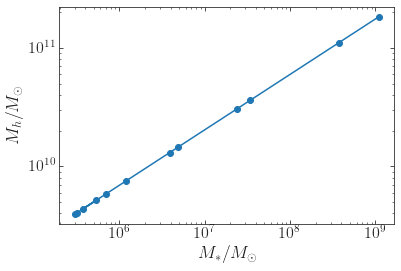

In [4]:
loglog(stellarmass,halo_mass(stellarmass),'o-')
xlabel(r'$M_*/M_\odot$')
ylabel(r'$M_h/M_\odot$');

Later we will extrapolate our measurements from the inner halo to the 300 kpc volume by assuming the Einasto spatial profile:

In [5]:
def spatial_profile(r,alpha=0.678,rm2=162.4):
    # Einasto, r in kpc
    return numpy.exp(-2./alpha*((r/rm2)**alpha-1.))

In [6]:
observed_volume= 23. # kpc
scale_to_300kpc= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]\
                    /integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]

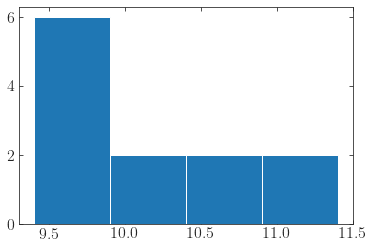

In [7]:
# Don't consider LMC/SMC
num_sats,e,_=hist(numpy.log10(halomass)[:],range=[9.4,11.4],bins=4);
mass_bins= 10.**((numpy.roll(e,1)+e)[1:]/2.)

In [8]:
mass_bins, num_sats

(array([4.46683592e+09, 1.41253754e+10, 4.46683592e+10, 1.41253754e+11]),
 array([6., 2., 2., 2.]))

## Our dark subhalo measurements

Then we add our dark subhalo measurements. Here I will just assume that what we measure is exactly the fiducial rate, but these could easily be replaced by our actual measurements (+errorbars).

The following are a bunch of functions to compute our fiducial rate:

In [9]:
def mass_function(m,c0=2.02*1e-13,m0=2.52*1e7,alpha=-1.9):
    return c0*(m/m0)**alpha

In [10]:
low_mass_bins_e= [10.**6.,10.**7.,10.**8.,10.**9.]
low_mass_bins= 10.**((numpy.roll(numpy.log10(low_mass_bins_e),1)+numpy.log10(low_mass_bins_e))[1:]/2.)

The following is the number of subhalos for ``rate=1``:

In [11]:
num_subs_cdm= numpy.array([integrate.quad(lambda m: mass_function(m),low_mass_bins_e[ii],low_mass_bins_e[ii+1])[0]\
              *integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,observed_volume)[0]
          for ii in range(len(low_mass_bins))])

The actual measured number is relative to this

In [12]:
num_subs_obs= numpy.array([numpy.nan,0.2,0.2])
num_subs_obs_err_up= numpy.array([numpy.nan,0.7,0.5])
num_subs_obs_err_lo= numpy.array([numpy.nan,0.1,0.1])
num_subs_up_lim= numpy.array([3.6,numpy.nan,numpy.nan])

Now we combine everything:

In [13]:
def plot_massfunction(add_mwdm=False,savefilename=None,
                      add_wdmmodels=False,
                      wdm_model=None,
                      thispaper=True,
                      pred_amp_fac=1.6):
    color_us= sns.color_palette("Paired")[1]
    bovy_plot.bovy_plot(low_mass_bins,num_subs_obs*num_subs_cdm*scale_to_300kpc,
                        marker='o',loglog=True,color=color_us,ls='none',
                        xlabel=r'$M_h/M_\odot$',ylabel=r'$dN/d\log_{10} M$',
                        xrange=[3e5*(True^add_wdmmodels)+3e4*add_wdmmodels,1e12],
                        yrange=[8e-2*pred_amp_fac,4e4*pred_amp_fac])
    if thispaper:
        label=r'$\mathrm{Streams}\,(\mathrm{Banik\ et\ al.\,2019;\, this\ paper)}$'
    else:
        label=r'$\mathrm{Streams}\,(\mathrm{Banik\ et\ al.\,2019)}$'            
    line_us= errorbar(low_mass_bins,num_subs_obs*num_subs_cdm*scale_to_300kpc,
                      yerr=[num_subs_obs_err_lo*num_subs_cdm*scale_to_300kpc,
                      num_subs_obs_err_up*num_subs_cdm*scale_to_300kpc],
                      marker='o',ls='none',color=color_us,ms=8.,mew=2.,
                      label=label)
    errorbar(low_mass_bins,num_subs_up_lim*num_subs_cdm*scale_to_300kpc,
             yerr=num_subs_up_lim*num_subs_cdm*scale_to_300kpc/2.01,
             uplims=True,mew=2.,
             marker='_',ls='none',color=color_us,ms=10.)
    line_sats= errorbar(mass_bins,2*num_sats,yerr=2*numpy.sqrt(num_sats),
                        marker='*',ls='none',color=sns.color_palette("Paired")[5],ms=12.,
                        label=r'$\mathrm{Classical\ MW\ satellites}$')
    # Prediction
    pred_ms= 10.**numpy.linspace(6.,11.5,11)
    mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
    prediction_cdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function(m),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                 *mwvol for ii in range(len(pred_ms))])
    line_pred_cdm= loglog(pred_ms,prediction_cdm,lw=2.,color='k',
                          label=r'$\mathrm{DM\ only}$',zorder=5)
    low_indx= pred_ms < 1e9
    line_pred= fill_between(pred_ms[low_indx],
                            0.1*prediction_cdm[low_indx],0.5*prediction_cdm[low_indx],
                            color='0.75',zorder=0,
                           label=r'$\mathrm{incl.\ baryonic\, disruption}$')
    if add_wdmmodels:
        pred_ms= 10.**numpy.linspace(6.,11.5,201)
        mwdms= [3.,6.,9.,12.,15.,20]
        text_heights= [3e0,3e1,1.25e2,3e2,6e2,1.3e3]
        for mwdm,text_height in zip(mwdms,text_heights):
            prediction_wdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_wdm(m,mwdm=mwdm),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                      *mwvol for ii in range(len(pred_ms))])
            prediction_wdm[(pred_ms>=10**8.7)*(pred_ms<10**9.7)]= numpy.nan
            line_pred_wdm= loglog(pred_ms,prediction_wdm,lw=2.,
                                  zorder=1,
                                  color=sns.color_palette()[1])
            bovy_plot.bovy_text(1e5,text_height,r'${:d}\,\mathrm{{keV}}$'.format(int(mwdm)),
                                size=17.,color=sns.color_palette()[1])
    if not wdm_model is None:
        pred_ms= 10.**numpy.linspace(6.,11.5,201)
        prediction_wdm= pred_amp_fac*numpy.array([integrate.quad(lambda m: mass_function_wdm(m,
                                                                                c0=numpy.exp(wdm_model[2])\
                                                                                    *2.02*1e-13,
                                                                                alpha=wdm_model[1],
                                                                                mwdm=1./wdm_model[0]),
                                            pred_ms[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*pred_ms[ii])[0]\
                                      *mwvol for ii in range(len(pred_ms))])
        prediction_wdm[(pred_ms>=10**8.7)*(pred_ms<10**9.7)]= numpy.nan
        line_pred_wdm= loglog(pred_ms,prediction_wdm,lw=2.,
                              zorder=1,
                              color=sns.color_palette()[1])
    l1= legend(handles=[line_us,line_sats],
           framealpha=1.,facecolor='w',edgecolor='none',
           fontsize=17.,loc='lower left',frameon=False)
    l2= legend(handles=[line_pred_cdm[0],line_pred],
           framealpha=1.,facecolor='w',edgecolor='none',
           fontsize=17.,loc='upper right',frameon=False)
    gca().add_artist(l1)
    gca().add_artist(l2)
    if add_mwdm:
        def mhalo_to_mwdm(mh):
            return 3.3*(mh/3e8)**-0.3
        minM,maxM= gca().get_xlim()
        ax2= gca().twiny()
        ax2.set_xlim(mhalo_to_mwdm(minM),mhalo_to_mwdm(maxM))
        ax2.set_xlabel(r'$m_{\mathrm{WDM}}/\mathrm{keV}$')
        ax2.set_xscale('log')
        ax2.xaxis.set_major_formatter(ticker.FormatStrFormatter(r'$%0.f$'))
    if not savefilename is None:
        bovy_plot.bovy_end_print(savefilename)

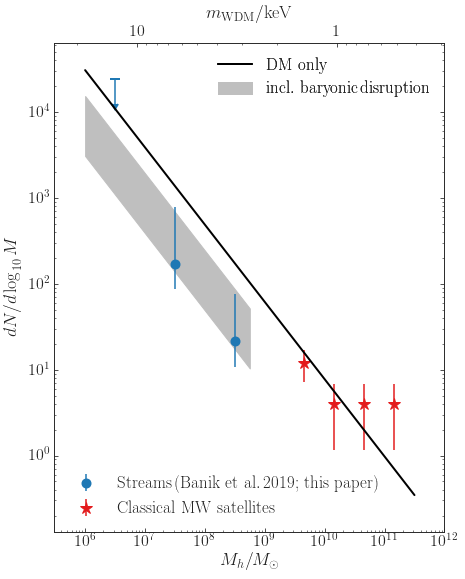

In [14]:
figsize(7,9)
plot_massfunction(add_mwdm=True)#,savefilename='subhalo_massfunction.pdf')

In [15]:
# Stuff to define the WDM mass function
nu=1.12
OmDM=0.2589
h=0.6774
c0Mpc=2.02*10**(-4) #Msun^-1 Mpc^-3
c0kpc=2.02*10**(-13) #Msun^-1 kpc^-3
m0=2.52*10**7 #Msun
beta=-0.99
gamma=2.7
mf_slope=-1.9
al=0.678 #alpha_shape
rm2=199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
Om_m=0.3089
rho_c=1.27*10**11 #Msun/Mpc^3
rho_bar=Om_m*rho_c
# smoothly go to reduced CDM expectation below 10^9.5
red_fac= 10.**(0.5*(numpy.log10(0.1)+numpy.log10(0.5)))
# Functions to define the WDM mass function
def alpha(m_wdm):
    return (0.048/h)*(m_wdm)**(-1.11) #in Mpc , m_wdm in keV
def lambda_hm(m_wdm):
    return 2*numpy.pi*alpha(m_wdm)/(2**(nu/5.) - 1.)**(1/(2*nu))
def M_hm(m_wdm):
    return (4*numpy.pi/3)*rho_bar*(lambda_hm(m_wdm)/2.)**3
def mass_function_wdm(m,c0=2.02*1e-13,m0=2.52*1e7,alpha=-1.9,
                      mwdm=2000.,gamma=2.7,beta=0.99,Mhm=None,
                      smooth_reduction=False,internal_red_fac=red_fac):
    if smooth_reduction:
        reduction= (internal_red_fac+(1.-internal_red_fac)*2./numpy.pi*numpy.arctan(m/10**9.25))
    else:
        reduction= numpy.ones_like(m)
        reduction[m<10**9.2]= internal_red_fac
    if Mhm is None:
        return c0*(m/m0)**alpha*(1.+gamma*(M_hm(mwdm)/m))**-beta*reduction
    else:
        return c0*(m/m0)**alpha*(1.+gamma*(Mhm/m))**-beta*reduction

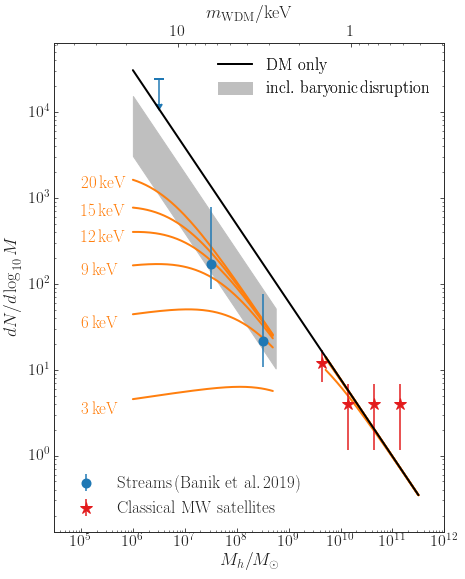

In [16]:
figsize(7,9)
plot_massfunction(add_mwdm=True,add_wdmmodels=True,thispaper=False)#,savefilename='subhalo_massfunction_wwdm.pdf')

## Constraining the warm dark matter mass

Next, we run MCMC fits to the observations of the number of subhalos in different mass ranges to constrain the warm dark matter mass. First, we make approximate representation's of Banik et al.'s results in the $10^7 -- 10^8\,M_\odot$ and $10^8 -- 10^9\,M_\odot$ PDFs:

In [17]:
from scipy.stats import poisson
from scipy import optimize
import emcee
import corner

In [18]:
def skew_lnpdf(rate,peak=-0.7,sig_up=0.6,sig_lo=0.3,exponent=2.):
    out= numpy.empty_like(rate)
    out[rate<peak]= -0.5*numpy.fabs(rate[rate<peak]-peak)**exponent/sig_lo**2.
    out[rate>=peak]= -0.5*numpy.fabs(rate[rate>=peak]-peak)**exponent/sig_up**2.   
    return out
def skew_lnpdf_1e8to9(rate):
    return skew_lnpdf(rate,peak=-0.7,sig_up=0.6,sig_lo=0.3,exponent=2.)
def skew_lnpdf_1e7to8(rate):
    return skew_lnpdf(rate,peak=-0.5,sig_up=0.5,sig_lo=0.5,exponent=2.5)

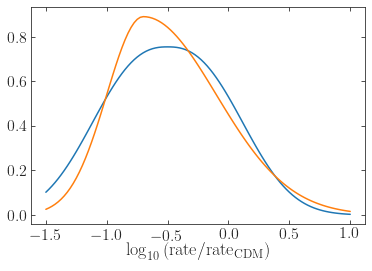

In [19]:
figsize(6,4)
rates= numpy.linspace(-1.5,1.,101)
pdf= numpy.exp(skew_lnpdf_1e7to8(rates))
pdf/= numpy.sum(pdf)*(rates[1]-rates[0])
plot(rates,pdf)
pdf= numpy.exp(skew_lnpdf_1e8to9(rates))
pdf/= numpy.sum(pdf)*(rates[1]-rates[0])
plot(rates,pdf)
xlabel(r'$\log_{10}\left(\mathrm{rate}/\mathrm{rate}_{\mathrm{CDM}}\right)$');

(blue is the lower mass bin)

Next, we write down the log likelihood. For the classical satellites, we use Poisson statistics, while for the lower-mass bins we use the distributions above. We implement three possible priors on the warm dark matter mass: (0) flat in 1/mass, (1) flat in log half-mode mass, and (2) flat in log mass.

In [20]:
mwvol= integrate.quad(lambda r: 4.*numpy.pi*r**2.*spatial_profile(r),0.,300.)[0]
def lnprob(p,wdm_prior=0):
    if wdm_prior == 0: # flat in 1/mwdm
        mwdm= 1./p[0]
    elif wdm_prior == 1: # flat in log10(M_hm)
        if p[0] < 4.8 or p[0] > 10.: return -10000000000000.
        mwdm= optimize.brentq(lambda w: M_hm(w)-10.**p[0],0.01,100.)
    elif wdm_prior == 2: # flat in log10(mwdm)
        mwdm= 10.**p[0]
        if mwdm < 1.225 or mwdm > 45: return -10000000000000.
    alpha= p[1]
    c0= numpy.exp(p[2])
    red_fac= 10.**p[3]
    if red_fac < 0.001 or red_fac > 0.5: return -10000000000000.
    if mwdm < 0.: return -10000000000000.
    if alpha < minalpha or alpha > maxalpha: return -10000000000000.
    if c0 < minc0 or c0 > maxc0: return -10000000000000.
    # Compute number of classical satellites predicted
    nclassical= numpy.array([integrate.quad(lambda m: mass_function_wdm(m,c0=c0*2.02*1e-13,
                                                                        alpha=alpha,mwdm=mwdm,
                                                                        internal_red_fac=red_fac),
                                            mass_bins[ii]/numpy.sqrt(10.**0.5),numpy.sqrt(10.**0.5)*mass_bins[ii])[0]\
                                 *mwvol for ii in range(len(mass_bins))])
    # ln like is Poisson
    out= numpy.sum([poisson.logpmf(num_sats[ii],nclassical[ii]) for ii in range(len(mass_bins)-1)])
    # Compute number of low-mass subhalos that we probe with streams and convert to rate
    nlowmass= numpy.array([integrate.quad(lambda m: mass_function_wdm(m,c0=c0*2.02*1e-13,
                                                                      alpha=alpha,mwdm=mwdm,
                                                                      internal_red_fac=red_fac),
                                            low_mass_bins[ii]/numpy.sqrt(10.),numpy.sqrt(10.)*low_mass_bins[ii])[0]\
                                 *mwvol for ii in range(len(low_mass_bins))])/num_subs_cdm/scale_to_300kpc
    out+= skew_lnpdf_1e7to8(numpy.log10(nlowmass[1]))+skew_lnpdf_1e8to9(numpy.log10(nlowmass[2]))
    return out
def lnlike(p,wdm_prior=0):
    return -lnprob(p,wdm_prior=wdm_prior)

We also implement some convenience functions to fit, MCMC sample, and plot the results:

In [21]:
def fit(wdm_prior=0):
    if wdm_prior == 0:
        init= [1./5.,-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 1:
        init= [numpy.log10(1e8),-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 2:
        init= [numpy.log10(5),-1.9,0.,numpy.log10(0.2)]
    return optimize.minimize(lambda x: lnlike(x,wdm_prior=wdm_prior),init,method='Powell')
def sample(wdm_prior=0,nwalkers=26,nburn=100,nsam=1000):
    # Setup initial ball
    if wdm_prior == 0:
        init= [1./5.,-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 1:
        init= [numpy.log10(1e8),-1.9,0.,numpy.log10(0.2)]
    elif wdm_prior == 2:
        init= [numpy.log10(5),-1.9,0.,numpy.log10(0.2)]
    ndim= len(init)
    # initial Gaussian ball
    p0= numpy.array(init)\
        +numpy.random.rand(ndim*nwalkers).reshape((nwalkers,len(init)))
    # Iterate until have points with non zero likelihood (within the prior rage)
    while True:
        lp= numpy.array([lnprob(p,wdm_prior=wdm_prior) for p in p0])
        if numpy.all(lp > -10000000000000.0): break
        indx= lp <= -10000000000000.0
        p0[indx]= numpy.array(init)\
            +numpy.random.rand(ndim*numpy.sum(indx)).reshape((numpy.sum(indx),ndim))
    # Setup sampler
    sampler= emcee.EnsembleSampler(nwalkers,ndim,lambda x: lnprob(x,wdm_prior=wdm_prior))
    pos, prob, state = sampler.run_mcmc(p0,nburn)
    sampler.reset()
    sampler.run_mcmc(pos,nsam)
    print("Mean acceptance fraction: {0:.3f}"
                    .format(np.mean(sampler.acceptance_fraction)))
    return sampler.flatchain
def plot_corner(flatchain,wdm_prior=0):
    plotthis= numpy.empty_like(flatchain)
    plotthis[:,0]= flatchain[:,0]
    plotthis[:,1]= flatchain[:,1]
    if wdm_prior == 0:
        mwdm_range= [0.,1.]
        wdm_label= r"$1/m_{\mathrm{WDM}}\,(\mathrm{keV}^{-1})$"
    elif wdm_prior == 1:
        mwdm_range= [4.8,10.]
        wdm_label= r"$\log_{10} M_{hm} / M_\odot$"
    elif wdm_prior == 2:
        mwdm_range= [numpy.log10(1.225),numpy.log10(45.)]
        wdm_label= r"$\log_{10} m_{\mathrm{WDM}} / \mathrm{keV}$"
    plotthis[:,2]= numpy.exp(flatchain[:,2])
    plotthis[:,3]= 10.**flatchain[:,3]
    fig= corner.corner(plotthis,labels=[wdm_label,r"$\alpha$",r"$c0$",r"$f_\mathrm{survive}$"],
                       range=[mwdm_range,[minalpha,maxalpha],[0.,5.],[0.01,0.5]],#[numpy.log10(0.01),numpy.log10(0.5)]],
                       quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})

Now we fit. We can set the prior range for the slope and amplitude of the mass function, so we set them to a wide range each:

In [22]:
minalpha, maxalpha= -3., -1.
minc0, maxc0= 1e-2, 1e2

The best fit:

In [23]:
opt= fit(wdm_prior=0)

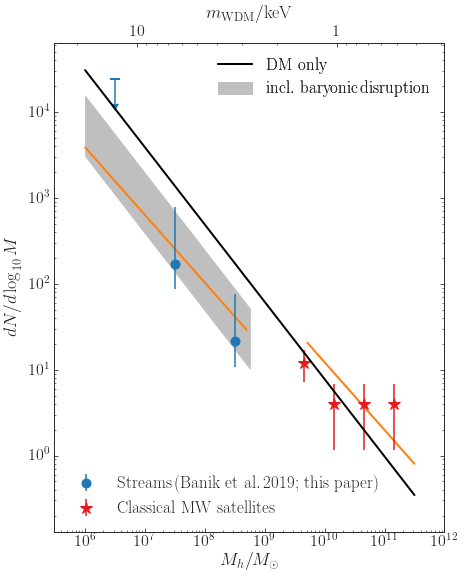

In [24]:
figsize(7,9)
plot_massfunction(add_mwdm=True,wdm_model=opt['x'])

Now we run the MCMC:

In [25]:
flatchain= sample(wdm_prior=0)

Mean acceptance fraction: 0.477


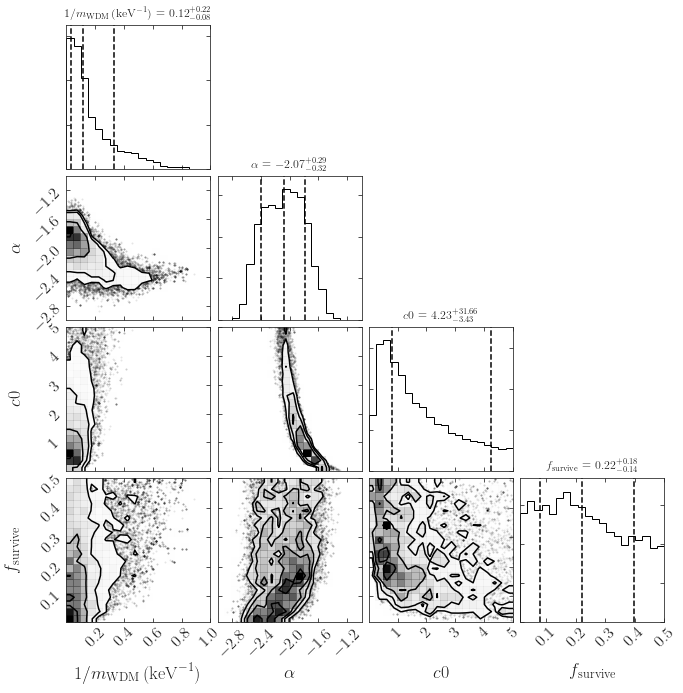

In [26]:
plot_corner(flatchain,wdm_prior=0)

In [27]:
print("The 68% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.32)))

The 68% lower limit on the warm dark matter mass is 5.19 keV


In [28]:
print("The 95% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.05)))

The 95% lower limit on the warm dark matter mass is 1.88 keV


In [29]:
print("The 99.7% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.003)))

The 99.7% lower limit on the warm dark matter mass is 1.26 keV


We can also run with tighter priors on the slope of the mass function:

In [30]:
minalpha, maxalpha= -1.95, -1.85

In [31]:
opt= fit(wdm_prior=0)

In [32]:
flatchain= sample(wdm_prior=0,nsam=3000)

Mean acceptance fraction: 0.483


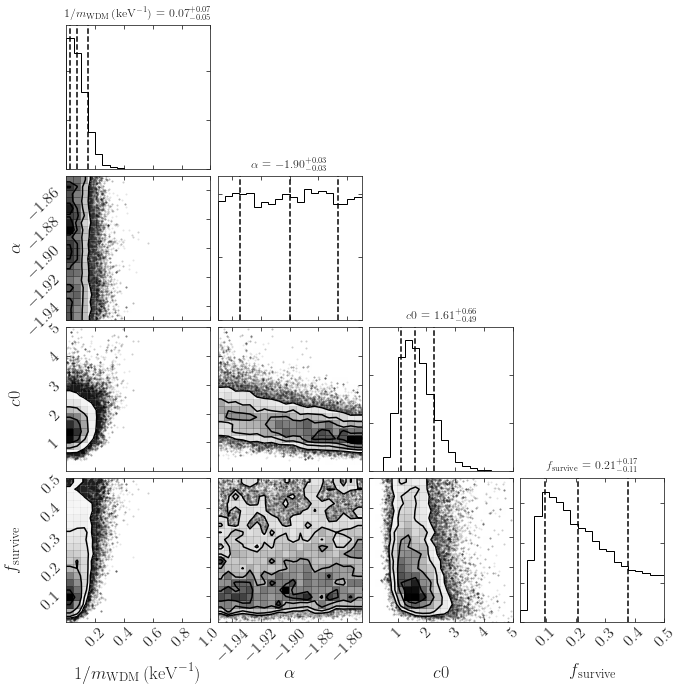

In [33]:
plot_corner(flatchain,wdm_prior=0)

In [34]:
print("The 68% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.32)))

The 68% lower limit on the warm dark matter mass is 9.40 keV


In [35]:
print("The 95% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.05)))

The 95% lower limit on the warm dark matter mass is 4.89 keV


In [36]:
print("The 99.7% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(1./flatchain[:,0],0.003)))

The 99.7% lower limit on the warm dark matter mass is 3.12 keV


Next, we run with a different prior on the mass of the warm dark matter particle, flat in log half-mode mass (this is the same as in the Gilman et al. (2019) strong-lensing paper:

In [37]:
opt= fit(wdm_prior=1)

In [38]:
flatchain= sample(wdm_prior=1,nsam=3000)

Mean acceptance fraction: 0.480


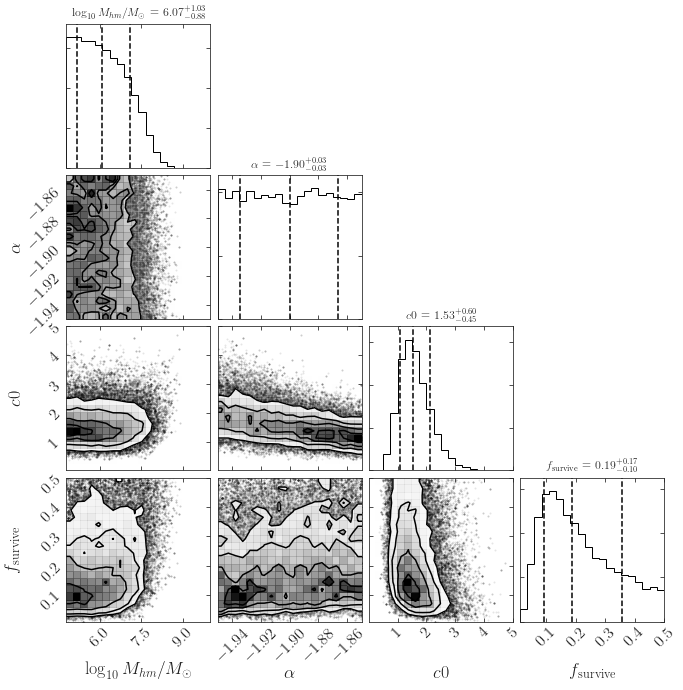

In [39]:
plot_corner(flatchain,wdm_prior=1)

In [40]:
print("The 68% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(optimize.brentq(lambda w: M_hm(w)-numpy.quantile(10.**flatchain[:,0],0.68),
                                 1.,100.)))

The 68% lower limit on the warm dark matter mass is 13.10 keV


In [41]:
print("The 95% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(optimize.brentq(lambda w: M_hm(w)-numpy.quantile(10.**flatchain[:,0],0.95),
                                 1.,100.)))

The 95% lower limit on the warm dark matter mass is 6.31 keV


In [42]:
print("The 99.7% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(optimize.brentq(lambda w: M_hm(w)-numpy.quantile(10.**flatchain[:,0],0.997),
                                 1.,100.)))

The 99.7% lower limit on the warm dark matter mass is 3.77 keV


Or expressed just as a constraint on the half-mode mass

In [43]:
print("The 68% upper limit on the half-mode mass is {:.2f} x 10^7 Msun"\
          .format(numpy.quantile(10.**(flatchain[:,0]-7.),0.68)))

The 68% upper limit on the half-mode mass is 0.38 x 10^7 Msun


In [44]:
print("The 95% upper limit on the half-mode mass is {:.2f} x 10^7 Msun"\
          .format(numpy.quantile(10.**(flatchain[:,0]-7.),0.95)))

The 95% upper limit on the half-mode mass is 4.28 x 10^7 Msun


In [45]:
print("The 99% upper limit on the half-mode mass is {:.2f} x 10^7 Msun"\
          .format(numpy.quantile(10.**(flatchain[:,0]-7.),0.997)))

The 99% upper limit on the half-mode mass is 23.73 x 10^7 Msun


We can also run with a prior that is flat in log warm-dark matter mass, but the results of that are about the same (the range of this prior is equivalent to that of the half-mode mass prior):

In [46]:
opt= fit(wdm_prior=2)

In [47]:
flatchain= sample(wdm_prior=2)

Mean acceptance fraction: 0.485


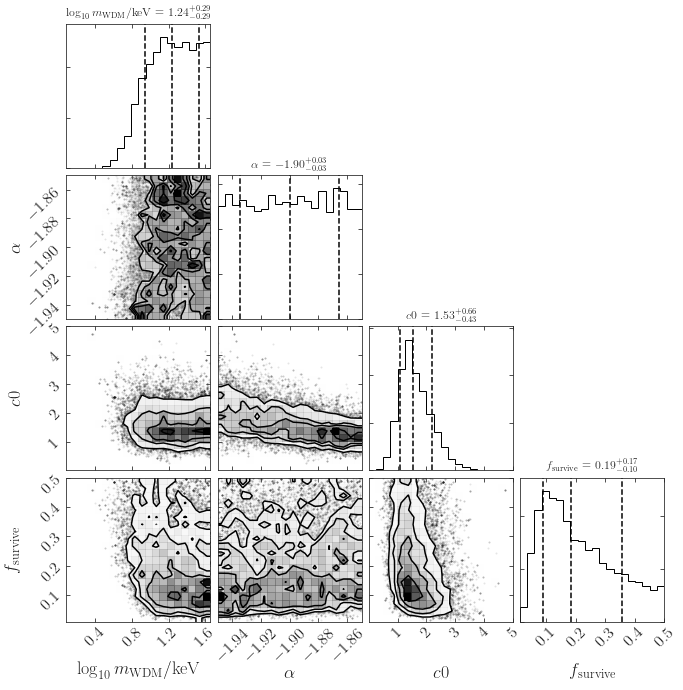

In [48]:
plot_corner(flatchain,wdm_prior=2)

In [49]:
print("The 68% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.32)))

The 68% lower limit on the warm dark matter mass is 12.41 keV


In [50]:
print("The 95% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.05)))

The 95% lower limit on the warm dark matter mass is 6.27 keV


In [51]:
print("The 99.7% lower limit on the warm dark matter mass is {:.2f} keV"\
          .format(numpy.quantile(10.**flatchain[:,0],0.003)))

The 99.7% lower limit on the warm dark matter mass is 3.83 keV
